In [ ]:
!pip install tensorflowjs

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm as tq
from collections import defaultdict
from PIL import Image
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files

# Import libraries untuk spilt data
from sklearn.model_selection import train_test_split


In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/ML/WISATA_JOGJA"

total_files = 0
class_file_counts = defaultdict(int)

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_files += 1
            label = os.path.basename(root)
            class_file_counts[label] += 1

# Tampilkan hasil
print(f"Total file gambar di dataset: {total_files}\n")
print("Jumlah file per kelas:")
for label, count in sorted(class_file_counts.items()):
    print(f"- {label}: {count} file")


Total file gambar di dataset: 3784

Jumlah file per kelas:
- Benteng_Vredeburg: 379 file
- Candi_Borobudur: 379 file
- Candi_Prambanan: 380 file
- Gedung_Agung_Istana_Kepresidenan_Yogyakarta: 380 file
- Masjid_Gedhe_Kauman: 378 file
- Monumen_Serangan_1Maret: 379 file
- Museum_Gunungapi_Merapi: 378 file
- Situs_Ratu_Boko: 376 file
- Taman_Sari: 375 file
- Tugu_Yogyakarta: 380 file


### Data Preprocessing

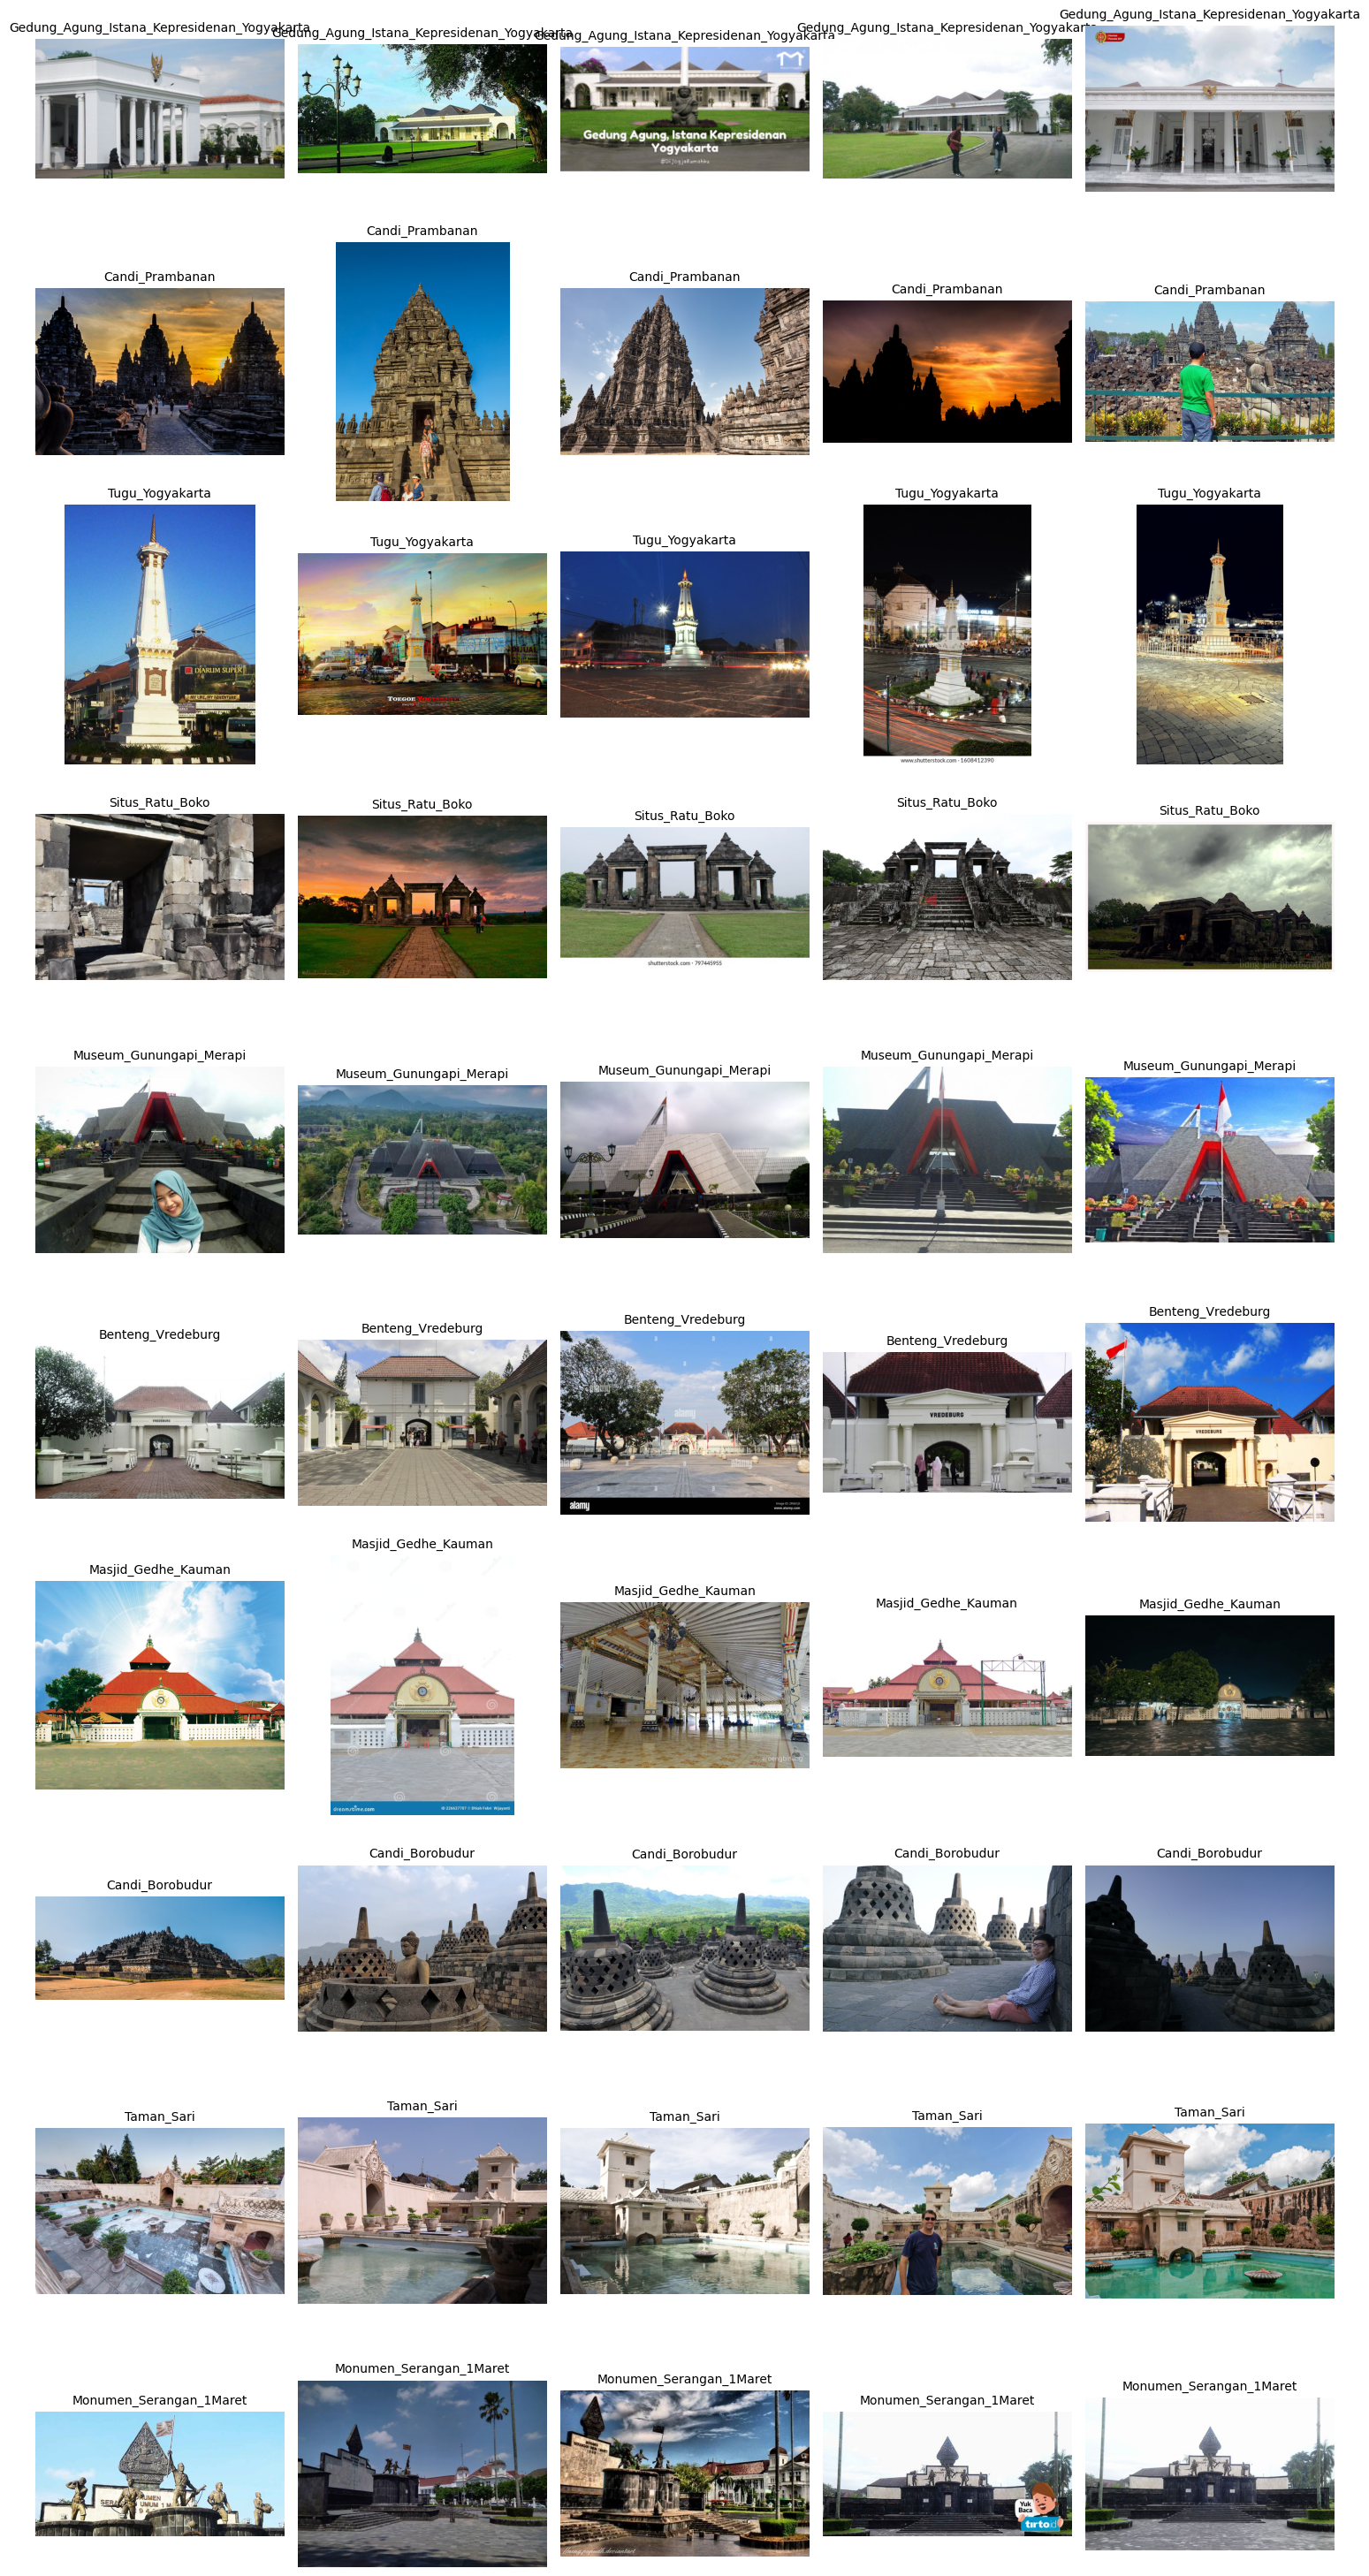

In [ ]:
# membuat sub class
wisata_image = {}
path_sub = "/content/drive/MyDrive/ML/WISATA_JOGJA"

# Loop untuk setiap kelas dan simpan nama filenya
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        wisata_image[class_name] = os.listdir(class_path)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(wisata_image), 5, figsize=(15, 3 * len(wisata_image)))

for i, (class_name, file_list) in enumerate(wisata_image.items()):
    selected_images = np.random.choice(file_list, 5, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=10)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


Teridentifikasi 0 file yang berpotensi rusak:


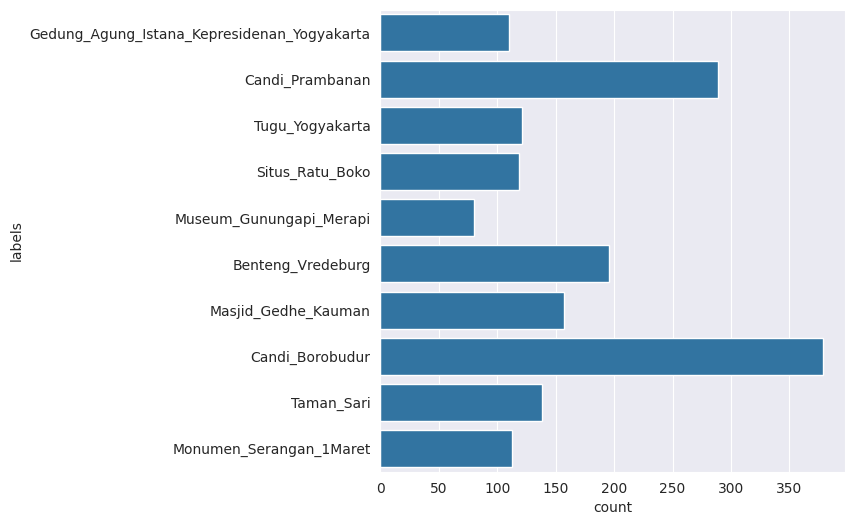

In [ ]:
wisata_path = "/content/drive/MyDrive/ML/WISATA_JOGJA"

file_name = []
labels = []
full_path = []
# mengambil data dari file name, labels, file_path dan mengecek file corupt
corrupted_files = []
for path, subdirs, files in os.walk(wisata_path):
    for name in files:
        file_full_path = os.path.join(path, name)
        # Lewati file yang bukan gambar berdasarkan ekstensi (opsional tapi disarankan)
        if not name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            img = Image.open(file_full_path)
            img.verify()
            full_path.append(file_full_path)
            labels.append(path.split('/')[-1])
            file_name.append(name)
        except Exception as e:
            print(f"Tidak dapat membuka atau memverifikasi file gambar: {file_full_path}. Error: {e}")
            corrupted_files.append(file_full_path)


distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

print(f"\nTeridentifikasi {len(corrupted_files)} file yang berpotensi rusak:")
for cf in corrupted_files:
    print(cf)

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Helper untuk memastikan output valid
def finalize_image(img):
    img = img.numpy() if hasattr(img, 'numpy') else img  # convert dari tf.Tensor kalau perlu
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    return img

def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return finalize_image(img)

def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return finalize_image(img)

def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return finalize_image(img)

def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return finalize_image(img)

def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy() if hasattr(img, 'numpy') else img
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return finalize_image(img)

def sheared(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return finalize_image(img)

def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return finalize_image(img)

In [ ]:
from collections import defaultdict

root_path = "/content/drive/MyDrive/ML/WISATA_JOGJA"
classes = ['Benteng_Vredeburg', 'Candi_Borobudur', 'Candi_Prambanan',
           'Gedung_Agung_Istana_Kepresidenan_Yogyakarta', 'Masjid_Gedhe_Kauman',
           'Monumen_Serangan_1Maret','Museum_Gunungapi_Merapi','Situs_Ratu_Boko',
           'Taman_Sari', 'Tugu_Yogyakarta']
class_counts = {}

for cls in classes:
    class_path = os.path.join(root_path, cls)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[cls] = count

print("Jumlah gambar per kelas:", class_counts)

Jumlah gambar per kelas: {'Benteng_Vredeburg': 197, 'Candi_Borobudur': 380, 'Candi_Prambanan': 289, 'Gedung_Agung_Istana_Kepresidenan_Yogyakarta': 110, 'Masjid_Gedhe_Kauman': 159, 'Monumen_Serangan_1Maret': 114, 'Museum_Gunungapi_Merapi': 82, 'Situs_Ratu_Boko': 123, 'Taman_Sari': 143, 'Tugu_Yogyakarta': 121}


In [ ]:
max_count = max(class_counts.values())

images_to_generate_per_class = {
    cls: max_count - count for cls, count in class_counts.items()
}

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

root_path = "/content/drive/MyDrive/ML/WISATA_JOGJA"
augmented_suffix = "_augmented"

# Augmentasi per kelas
for cls in classes:
    images_path = os.path.join(root_path, cls)
    augmented_path = os.path.join(root_path, cls + augmented_suffix)

    os.makedirs(augmented_path, exist_ok=True)

    images = [os.path.join(images_path, im) for im in os.listdir(images_path)]

    to_generate = images_to_generate_per_class[cls]
    print(f"Augmenting class: {cls} | Need to generate: {to_generate}")

    i = 1
    while i <= to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)

            if original_image.ndim != 3:
                raise ValueError("Invalid image dimensions")

            transformed_image = original_image
            n = 0
            transformation_count = random.randint(1, len(transformations))

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)
                n += 1

            new_image_path = os.path.join(augmented_path, f"aug_{cls}_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1

        except Exception as e:
            print(f'Could not process image {image} : {e}, skipping.')

Augmenting class: Benteng_Vredeburg | Need to generate: 183
Augmenting class: Candi_Borobudur | Need to generate: 0
Augmenting class: Candi_Prambanan | Need to generate: 91
Augmenting class: Gedung_Agung_Istana_Kepresidenan_Yogyakarta | Need to generate: 270
Augmenting class: Masjid_Gedhe_Kauman | Need to generate: 221
Augmenting class: Monumen_Serangan_1Maret | Need to generate: 266
Augmenting class: Museum_Gunungapi_Merapi | Need to generate: 298
Augmenting class: Situs_Ratu_Boko | Need to generate: 257
Augmenting class: Taman_Sari | Need to generate: 237
Augmenting class: Tugu_Yogyakarta | Need to generate: 259


In [ ]:
for cls in classes:
    original_folder = os.path.join(root_path, cls)
    augmented_folder = os.path.join(root_path, cls + "_augmented")

    # Cek apakah folder augmentasi ada
    if not os.path.exists(augmented_folder):
        print(f"Folder {augmented_folder} tidak ditemukan, lewati...")
        continue

    # Pindahkan semua file dari folder augmented ke folder asli
    for filename in os.listdir(augmented_folder):
        src = os.path.join(augmented_folder, filename)
        dst = os.path.join(original_folder, filename)

        # Rename otomatis kalau ada nama file yang sama
        if os.path.exists(dst):
            name, ext = os.path.splitext(filename)
            new_name = f"{name}_copy{ext}"
            dst = os.path.join(original_folder, new_name)

        shutil.move(src, dst)

    # Hapus folder augmented setelah dipindah semua
    shutil.rmtree(augmented_folder)
    print(f"Selesai gabung: {cls}")

Selesai gabung: Benteng_Vredeburg
Selesai gabung: Candi_Borobudur
Selesai gabung: Candi_Prambanan
Selesai gabung: Gedung_Agung_Istana_Kepresidenan_Yogyakarta
Selesai gabung: Masjid_Gedhe_Kauman
Selesai gabung: Monumen_Serangan_1Maret
Selesai gabung: Museum_Gunungapi_Merapi
Selesai gabung: Situs_Ratu_Boko
Selesai gabung: Taman_Sari
Selesai gabung: Tugu_Yogyakarta


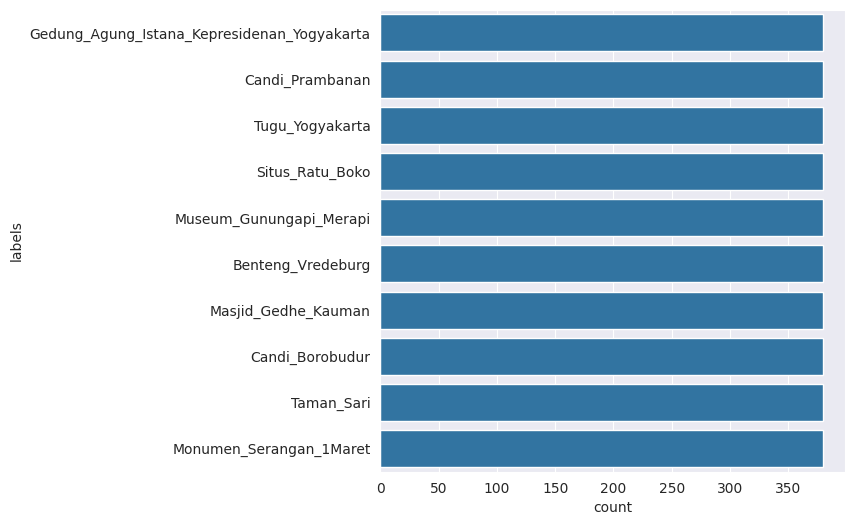

In [ ]:
wisata_path = "/content/drive/MyDrive/ML/WISATA_JOGJA"

file_name = []
labels = []
full_path = []


for path, subdirs, files in os.walk(wisata_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
mypath= "/content/drive/MyDrive/ML/WISATA_JOGJA"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

labels
Benteng_Vredeburg                              380
Candi_Borobudur                                380
Candi_Prambanan                                380
Gedung_Agung_Istana_Kepresidenan_Yogyakarta    380
Masjid_Gedhe_Kauman                            380
Monumen_Serangan_1Maret                        380
Museum_Gunungapi_Merapi                        380
Situs_Ratu_Boko                                380
Taman_Sari                                     380
Tugu_Yogyakarta                                380
dtype: int64

#### Split Dataset

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 3040
test size 760


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels                                     
test   Benteng_Vredeburg                               73
       Candi_Borobudur                                 82
       Candi_Prambanan                                 82
       Gedung_Agung_Istana_Kepresidenan_Yogyakarta     74
       Masjid_Gedhe_Kauman                             81
       Monumen_Serangan_1Maret                         61
       Museum_Gunungapi_Merapi                         85
       Situs_Ratu_Boko                                 67
       Taman_Sari                                      70
       Tugu_Yogyakarta                                 85
train  Benteng_Vredeburg                              307
       Candi_Borobudur                                298
       Candi_Prambanan                                298
       Gedung_Agung_Istana_Kepresidenan_Yogyakarta    306
       Masjid_Gedhe_Kauman                            299
       Monumen_Serangan_1Maret                        319
       Museum_Gunung

In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/drive/MyDrive/ML/WISATA_JOGJA"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/drive/MyDrive/ML/Dataset-Final"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Define training and test directories
TRAIN_DIR = "/content/drive/MyDrive/ML/Dataset-Final/train"
TEST_DIR = "/content/drive/MyDrive/ML/Dataset-Final/test"

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

corrupted_files_train = []
print("Checking training directory for corrupted images...")
for subdir, _, files in os.walk(TRAIN_DIR):
    for file in files:
        filepath = os.path.join(subdir, file)
        # Skip non-image files based on extension (optional but good practice)
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            img = Image.open(filepath)
            img.verify()
            # Close the image file after verification
            img.close()
        except Exception as e:
            print(f"Corrupted or truncated image found: {filepath}. Error: {e}")
            corrupted_files_train.append(filepath)

if corrupted_files_train:
    print(f"\nFound {len(corrupted_files_train)} file corrupt di data train:")
    for cf in corrupted_files_train:
        print(cf)
    print("\nhapus data sebelum melanjutkan menggunakan data train")
else:
    print("\ntidak ada gambar corupt di data train")



Checking training directory for corrupted images...

tidak ada gambar corupt di data train


In [ ]:
# buat ImageDataGenerator untuk normalisasi gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2425 images belonging to 10 classes.
Found 602 images belonging to 10 classes.
Found 757 images belonging to 10 classes.


## Modelling

In [ ]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Add Conv2D + MaxPooling2D + Classifier
x = base_model.output
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
# Final model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.1208 - loss: 2.4828 - val_accuracy: 0.2990 - val_loss: 1.8989
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.2902 - loss: 1.9388 - val_accuracy: 0.5648 - val_loss: 1.4044
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.4162 - loss: 1.5956 - val_accuracy: 0.6528 - val_loss: 1.1480
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.5740 - loss: 1.2718 - val_accuracy: 0.7409 - val_loss: 0.8872
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.6665 - loss: 0.9804 - val_accuracy: 0.7608 - val_loss: 0.7453
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.7661 - loss: 0.7166 - val_accuracy: 0.7492 - val_loss: 0.8810
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - accuracy: 0.7867 - loss: 0.6528 - val_accuracy: 0.8040 - val_loss: 0.7474
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step - accuracy: 0.8371 - loss: 0.4725 - val_accurac

## Evaluasi dan Visualisasi

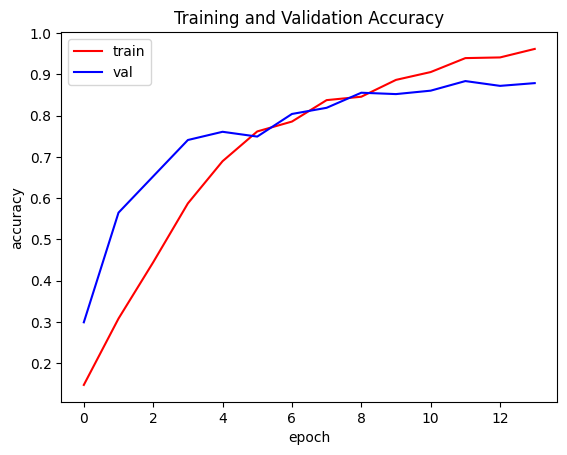

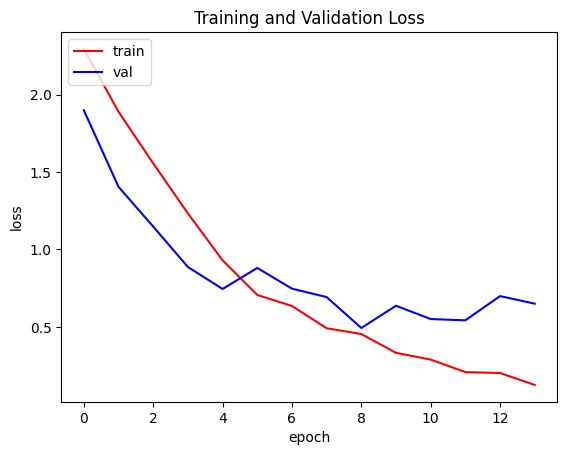

In [ ]:
# Mengambil nilai akurasi dan loss dari hasil training model
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Mendefinisikan jumlah epoch berdasarkan panjang history
epochs = range(len(acc))

# Menampilkan grafik akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Menampilkan grafik loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

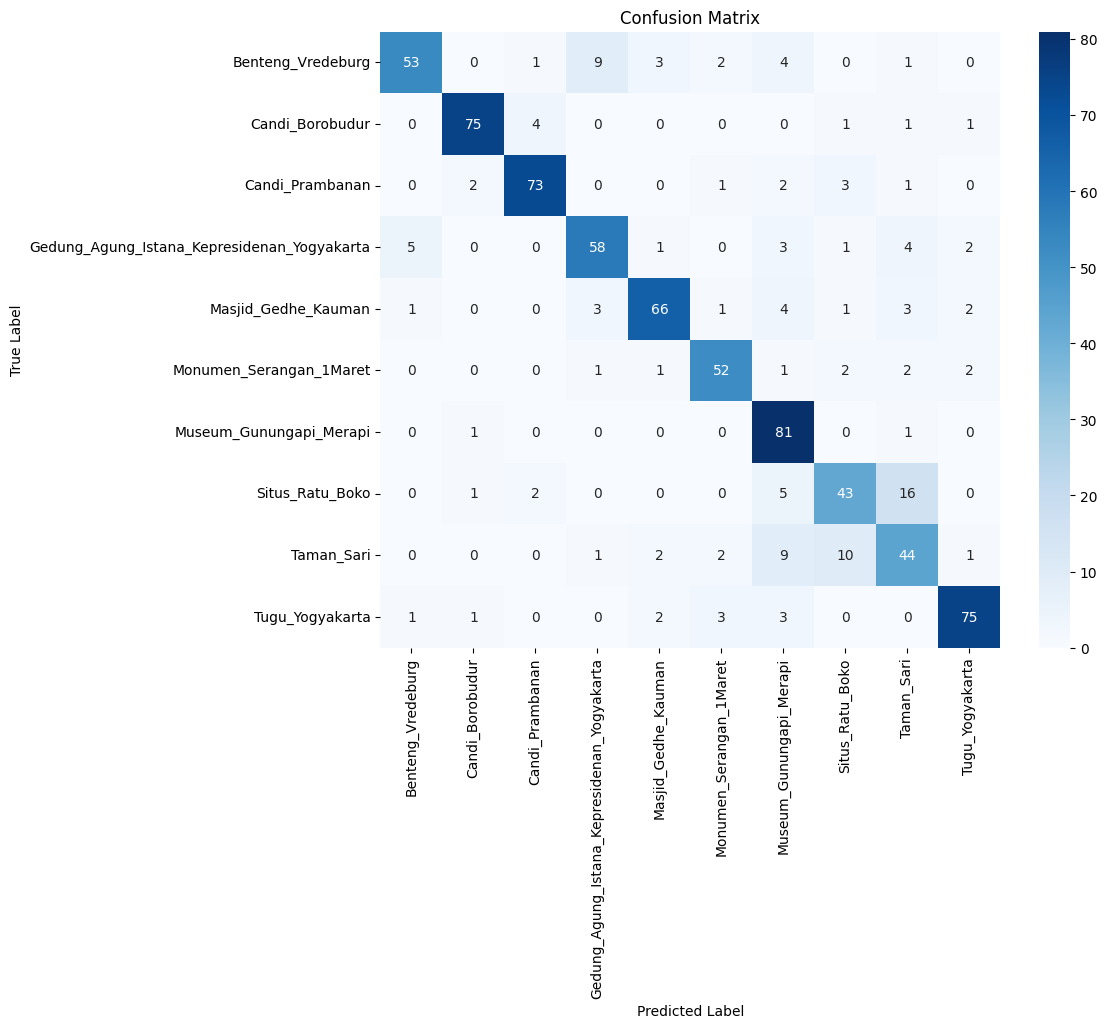


Classification Report:

                                             precision    recall  f1-score   support

                          Benteng_Vredeburg     0.8833    0.7260    0.7970        73
                            Candi_Borobudur     0.9375    0.9146    0.9259        82
                            Candi_Prambanan     0.9125    0.8902    0.9012        82
Gedung_Agung_Istana_Kepresidenan_Yogyakarta     0.8056    0.7838    0.7945        74
                        Masjid_Gedhe_Kauman     0.8800    0.8148    0.8462        81
                    Monumen_Serangan_1Maret     0.8525    0.8525    0.8525        61
                    Museum_Gunungapi_Merapi     0.7232    0.9759    0.8308        83
                            Situs_Ratu_Boko     0.7049    0.6418    0.6719        67
                                 Taman_Sari     0.6027    0.6377    0.6197        69
                            Tugu_Yogyakarta     0.9036    0.8824    0.8929        85

                                   acc

In [ ]:
# Reset test generator agar prediksi dimulai dari awal
test_generator.reset()

# Prediksi model (output probabilitas per kelas)
preds = model.predict(test_generator, verbose=0)

# Ambil prediksi kelas dengan argmax
predicted_classes = np.argmax(preds, axis=1)

# Ground truth label
true_classes = test_generator.classes

# Label nama kelas (urutannya sama dengan class_indices)
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

## Konversi Model

In [ ]:
# Simpan model ke file JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save("my_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('model.json')
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#simpan model dalam format saved model
model.export("saved_model/my_model")

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_326')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135607739525712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726606928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726607312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726607120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726603088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726608464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726608848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726609232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726609040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135602726602512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13560

In [ ]:
#simpan model dalam format tflite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
# Convert dari SavedModel
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_node_names='dense_2/Softmax' \
                        --saved_model_tags=serve \
                        saved_model/my_model tfjs_model/

In [ ]:
# membuat file label.txt
with open("label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("✅ File label.txt berhasil dibuat!")

✅ File label.txt berhasil dibuat!


In [ ]:
!pip freeze > requirements.txt

## Inference (Optional)

In [ ]:
label = [
    "Benteng_Vredeburg",
    "Candi_Borobudur",
    "Candi_Prambanan",
    "Gedung_Agung_Istana_Kepresidenan_Yogyakarta",
    "Masjid_Gedhe_Kauman",
    "Monumen_Serangan_1Maret",
    "Museum_Gunungapi_Merapi",
    "Situs_Ratu_Boko",
    "Taman_Sari",
    "Tugu_Yogyakarta"
]

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = load_img(image_path, color_mode='rgb', target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        return img_array
    except Exception as e:
        print(f"Error memproses gambar {image_path}: {e}")
        return None

def predict_image(model, image_path, class_labels):
    processed_img = preprocess_image(image_path)

    if processed_img is not None:
        predictions = model.predict(processed_img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_label = class_labels[predicted_class_index]
        confidence = np.max(predictions)
        print(f"Prediksi: {predicted_label} dengan confidence {confidence:.4f}")
        return predicted_label
    else:
        return "Gagal memproses gambar."

class_names = list(train_generator.class_indices.keys())
user_image_path = '/content/drive/MyDrive/ML/WISATA_JOGJA/Taman_Sari/Image_144.jpg'
predicted_class = predict_image(model, user_image_path, class_names)

print(f"Gambar {user_image_path} diprediksi sebagai: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi: Taman_Sari dengan confidence 0.5470
Gambar /content/drive/MyDrive/ML/WISATA_JOGJA/Taman_Sari/Image_144.jpg diprediksi sebagai: Taman_Sari


In [ ]:
user_image_path = '/content/drive/MyDrive/ML/WISATA_JOGJA/Candi_Borobudur/33355376398.jpg' # Contoh path gambar
predicted_class = predict_image(model, user_image_path, class_names)

print(f"Gambar {user_image_path} diprediksi sebagai: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi: Candi_Borobudur dengan confidence 0.4386
Gambar /content/drive/MyDrive/ML/WISATA_JOGJA/Candi_Borobudur/33355376398.jpg diprediksi sebagai: Candi_Borobudur


In [ ]:
user_image_path = '/content/drive/MyDrive/ML/WISATA_JOGJA/Candi_Prambanan/42127025384.jpg' # Contoh path gambar
predicted_class = predict_image(model, user_image_path, class_names)

print(f"Gambar {user_image_path} diprediksi sebagai: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediksi: Candi_Prambanan dengan confidence 0.9987
Gambar /content/drive/MyDrive/ML/WISATA_JOGJA/Candi_Prambanan/42127025384.jpg diprediksi sebagai: Candi_Prambanan


In [ ]:
user_image_path = '/content/drive/MyDrive/ML/WISATA_JOGJA/Gedung_Agung_Istana_Kepresidenan_Yogyakarta/Image_11.jpg' # Contoh path gambar
predicted_class = predict_image(model, user_image_path, class_names)

print(f"Gambar {user_image_path} diprediksi sebagai: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediksi: Gedung_Agung_Istana_Kepresidenan_Yogyakarta dengan confidence 0.8978
Gambar /content/drive/MyDrive/ML/WISATA_JOGJA/Gedung_Agung_Istana_Kepresidenan_Yogyakarta/Image_11.jpg diprediksi sebagai: Gedung_Agung_Istana_Kepresidenan_Yogyakarta


In [ ]:
user_image_path = '/content/drive/MyDrive/ML/WISATA_JOGJA/Monumen_Serangan_1Maret/Image_10.jpg' # Contoh path gambar
predicted_class = predict_image(model, user_image_path, class_names)

print(f"Gambar {user_image_path} diprediksi sebagai: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediksi: Monumen_Serangan_1Maret dengan confidence 1.0000
Gambar /content/drive/MyDrive/ML/WISATA_JOGJA/Monumen_Serangan_1Maret/Image_10.jpg diprediksi sebagai: Monumen_Serangan_1Maret


In [ ]:
user_image_path = '/content/drive/MyDrive/ML/WISATA_JOGJA/Situs_Ratu_Boko/Image_5.jpg' # Contoh path gambar
predicted_class = predict_image(model, user_image_path, class_names)

print(f"Gambar {user_image_path} diprediksi sebagai: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediksi: Situs_Ratu_Boko dengan confidence 0.9358
Gambar /content/drive/MyDrive/ML/WISATA_JOGJA/Situs_Ratu_Boko/Image_5.jpg diprediksi sebagai: Situs_Ratu_Boko
